## 2024 CVE Data Review Intro

In [1]:
%%capture
#!rm nvd.jsonl
#!wget -q https://nvd.handsonhacking.org/nvd.jsonl

In [2]:
from IPython.core.magic import register_cell_magic
from IPython.display import Markdown
import datetime
from datetime import date
import glob
import json
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly
import warnings
import calplot
from itables import init_notebook_mode, show
import itables.options as opt

opt.dom = "tpir"
opt.style = "table-layout:auto;width:auto"
init_notebook_mode(all_interactive=True, connected=True)

@register_cell_magic
def markdown(line, cell):
    return Markdown(cell.format(**globals()))


logging.getLogger('matplotlib.font_manager').disabled = True
warnings.filterwarnings("ignore")
pd.set_option('display.width', 500)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 10)

In [3]:
row_accumulator = []
for filename in glob.glob('nvd.jsonl'):
    with open(filename, 'r', encoding='utf-8') as f:
        nvd_data = json.load(f)
        for entry in nvd_data:
            cve = entry['cve']['id']
            try:
                assigner = entry['cve']['sourceIdentifier']
            except KeyError:
                assigner = 'Missing_Data'
            try:
                published_date = entry['cve']['published']
            except KeyError:
                published_date = 'Missing_Data'
            try:
                attack_vector = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['attackVector']
            except KeyError:
                attack_vector = 'Missing_Data'
            try:
                attack_complexity = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['attackComplexity']
            except KeyError:
                attack_complexity = 'Missing_Data'
            try:
                privileges_required = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['privilegesRequired']
            except KeyError:
                privileges_required = 'Missing_Data'
            try:
                user_interaction = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['userInteraction']
            except KeyError:
                user_interaction = 'Missing_Data'
            try:
                scope = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['scope']
            except KeyError:
                scope = 'Missing_Data'
            try:
                confidentiality_impact = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['confidentialityImpact']
            except KeyError:
                confidentiality_impact = 'Missing_Data'
            try:
                integrity_impact = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['integrityImpact']
            except KeyError:
                integrity_impact = 'Missing_Data'
            try:
                availability_impact = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['availabilityImpact']
            except KeyError:
                availability_impact = 'Missing_Data'
            try:
                base_score = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['baseScore']
            except KeyError:
                base_score = '0.0'
            try:
                base_severity = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['baseSeverity']
            except KeyError:
                base_severity = 'Missing_Data'
            try:
                exploitability_score = entry['cve']['metrics']['cvssMetricV31'][0]['exploitabilityScore']
            except KeyError:
                exploitability_score = 'Missing_Data'
            try:
                impact_score = entry['cve']['metrics']['cvssMetricV31'][0]['impactScore']
            except KeyError:
                impact_score = 'Missing_Data'
            try:
                cwe = entry['cve']['weaknesses'][0]['description'][0]['value']
            except KeyError:
                cwe = 'Missing_Data'
            try:
                description = entry['cve']['descriptions'][0]['value']
            except IndexError:
                description = ''
            try: 
                vulnStatus = entry['cve']['vulnStatus']
            except IndexError:
                vulnStatus = ''  
            new_row = {
                'CVE': cve,
                'Published': published_date,
                'AttackVector': attack_vector,
                'AttackComplexity': attack_complexity,
                'PrivilegesRequired': privileges_required,
                'UserInteraction': user_interaction,
                'Scope': scope,
                'ConfidentialityImpact': confidentiality_impact,
                'IntegrityImpact': integrity_impact,
                'AvailabilityImpact': availability_impact,
                'BaseScore': base_score,
                'BaseSeverity': base_severity,
                'ExploitabilityScore': exploitability_score,
                'ImpactScore': impact_score,
                'CWE': cwe,
                'Description': description,
                'Assigner' : assigner,
                'Status': vulnStatus 
            }
            row_accumulator.append(new_row)
        nvd = pd.DataFrame(row_accumulator)

nvd = nvd[nvd.Status.str.contains('Rejected')]
nvd['Published'] = pd.to_datetime(nvd['Published'])
thisyear = ((nvd['Published'] > '2024-01-01') & (nvd['Published']  < '2025-01-01'))
nvd = nvd.loc[thisyear]
nvd = nvd.sort_values(by=['Published'])
nvd = nvd.reset_index(drop=True)
nvd['BaseScore'] = pd.to_numeric(nvd['BaseScore']);
nvd['BaseScore'] = pd.to_numeric(nvd['BaseScore']);
nvd['BaseScore'] = nvd['BaseScore'].replace(0, np.nan);
nvdcount = nvd['Published'].count()
nvdunique = nvd['Published'].nunique()
startdate = date(2024, 1, 1)
enddate  = date(2025,1,1)
numberofdays = enddate - startdate 
per_day = nvdcount/numberofdays.days

In [11]:
Markdown(f"Total Number of CVEs: **{nvd['CVE'].count()}**<br />Average CVEs Per Day: **{per_day.round(2)}**<br />**")

Total Number of CVEs: **695**<br />Average CVEs Per Day: **1.9**<br />**

## Top 10 Publishing Days

In [12]:
Month_Graph = nvd['Published'].groupby(nvd.Published.dt.to_period("M")).agg('count')
Year_Graph = nvd['Published'].groupby(nvd.Published.dt.to_period("Y")).agg('count')
Week_Graph = nvd['Published'].groupby(nvd.Published.dt.to_period("W")).agg('count')
Day_Graph = nvd['Published'].groupby(nvd.Published.dt.to_period("D")).agg('count')

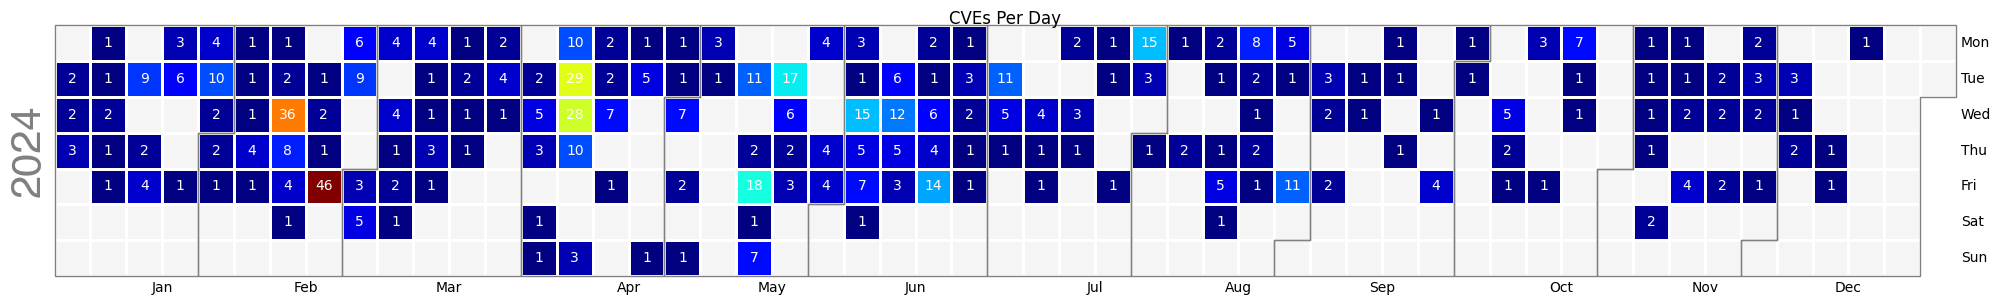

In [13]:
dfs = nvd['Published'].apply(lambda x: pd.to_datetime(x, errors='coerce', format='%Y/%m/%d'))
df = dfs.value_counts()
df = df.to_frame()
df.index = df.index.strftime('%m/%d/%Y')
df.index = pd.to_datetime(df.index, format='%m/%d/%Y')
calplot.calplot(df.T.squeeze(), cmap='jet', dropzero=True, edgecolor="Grey", textcolor="White", textformat='{:.0f}', textfiller='', suptitle='CVEs Per Day', figsize=(25,3));

In [14]:
dg_df = pd.DataFrame(Day_Graph)
dg_df.columns = ['Count']
dg_df = dg_df.reset_index()
dg_df = dg_df.rename(columns={"Published" : "Date"})
dg_df['Percentage'] = ( dg_df['Count'] / 
                       dg_df['Count'].sum()) * 100
dg_df['Percentage'] = dg_df['Percentage'].round(2)
dg_df = dg_df.rename(columns={"Count" : "CVEs"})
dg_df_top_10 = dg_df.sort_values(by='CVEs', ascending=False).head(10)
dg_df_top_10.to_csv("dg_df_top_10.csv", index=False)
dg_df_top_10

Date  CVEs  Percentage
33   2024-02-23    46        6.62
26   2024-02-14    36        5.18
61   2024-04-09    29        4.17
62   2024-04-10    28        4.03
81   2024-05-17    18        2.59
84   2024-05-21    17        2.45
93   2024-06-05    15        2.16
123  2024-07-29    15        2.16
105  2024-06-21    14        2.01
98   2024-06-12    12        1.73

## Publishing Month

In [15]:
mg_df = pd.DataFrame(Month_Graph)
mg_df.columns = ['Count']
mg_df = mg_df.reset_index()
mg_df = mg_df.rename(columns={"Published" : "Month"})
mg_df['Percentage'] = ( mg_df['Count'] / 
                       mg_df['Count'].sum()) * 100
mg_df['Month'] = mg_df['Month'].dt.strftime('%B')
mg_df['Percentage'] = mg_df['Percentage'].round(1)
mg_df = mg_df.rename(columns={"Count" : "CVEs"})
mg_df.to_csv("mg_df.csv", index=False)
mg_df

Month  CVEs  Percentage
0     January    54         7.8
1    February   128        18.4
2       March    42         6.0
3       April   113        16.3
4         May    93        13.4
5        June    93        13.4
6        July    50         7.2
7      August    45         6.5
8   September    18         2.6
9     October    22         3.2
10   November    28         4.0
11   December     9         1.3

## Day Of The Week

In [17]:
nvd_dow = nvd
nvd_dow['Day_Of_Week'] = nvd_dow['Published'].dt.strftime('%A')
nvd_dow = nvd_dow['Day_Of_Week'].value_counts()
nvd_dow = nvd_dow.reset_index()
nvd_dow = nvd_dow.rename(columns={"Day_Of_Week": "Day", "count": "Count"}, errors="raise")
nvd_dow['Percentage'] = (nvd_dow['Count'] / 
                       nvd_dow['Count'].sum()) * 100
nvd_dow = nvd_dow.round(1)
nvd_dow = nvd_dow.rename(columns={"Count" : "CVEs"})
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
nvd_dow['Day'] = pd.Categorical(nvd_dow['Day'], categories=cats, ordered=True)
nvd_dow = nvd_dow.sort_values('Day')
nvd_dow.to_csv("nvd_dow.csv", index=False)
nvd_dow

Day  CVEs  Percentage
3     Monday   105        15.1
1    Tuesday   163        23.5
0  Wednesday   171        24.6
4   Thursday    78        11.2
2     Friday   152        21.9
5   Saturday    13         1.9
6     Sunday    13         1.9